In [166]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from tqdm.auto import tqdm
import lightgbm as lgb
from sklearn import preprocessing
import sklearn
import datetime

In [167]:
coupon_area_test = pd.read_csv('./coupon-purchase-prediction/coupon_area_test.csv')
coupon_area_train = pd.read_csv('./coupon-purchase-prediction/coupon_area_train.csv')
coupon_detail_train = pd.read_csv('./coupon-purchase-prediction/coupon_detail_train.csv')
coupon_list_test = pd.read_csv('./coupon-purchase-prediction/coupon_list_test.csv')
coupon_list_train = pd.read_csv('./coupon-purchase-prediction/coupon_list_train.csv')
coupon_visit_train = pd.read_csv('./coupon-purchase-prediction/coupon_visit_train.csv')
prefecture_locations = pd.read_csv('./coupon-purchase-prediction/prefecture_locations.csv')
sample_submission = pd.read_csv('./coupon-purchase-prediction/sample_submission.csv')
user_list = pd.read_csv('./coupon-purchase-prediction/user_list.csv')

In [17]:
coupon_area_test.shape

(2165, 3)

In [18]:
coupon_area_test.head()

,SMALL_AREA_NAME,PREF_NAME,COUPON_ID_hash
0,京都,京都府,c76ea297ebd3a5a4d3bf9f75269f66fa
1,ミナミ他,大阪府,c76ea297ebd3a5a4d3bf9f75269f66fa
2,銀座・新橋・東京・上野,東京都,dd74dc95ca294afa02db40a543ae1763
3,川崎・湘南・箱根他,神奈川県,c65b550cbef918796ad53b1d5b7165c1
4,埼玉,埼玉県,c65b550cbef918796ad53b1d5b7165c1


In [19]:
coupon_area_train.head()

,SMALL_AREA_NAME,PREF_NAME,COUPON_ID_hash
0,埼玉,埼玉県,6b263844241eea98c5a97f1335ea82af
1,千葉,千葉県,cc031f250e8bad1e24060263b9fc0ddd
2,千葉,千葉県,ba5e9b7453ca52ff711635a5d2e8102d
3,千葉,千葉県,3e1ffbedca3569f9e8032d401e8cb4e6
4,千葉,千葉県,782934b6c815b4030ea204eef7d4a734


In [20]:
coupon_detail_train.head()

,ITEM_COUNT,I_DATE,SMALL_AREA_NAME,PURCHASEID_hash,USER_ID_hash,COUPON_ID_hash
0,1,2012-03-28 15:06:06,兵庫,c820a8882374a4e472f0984a8825893f,d9dca3cb44bab12ba313eaa681f663eb,34c48f84026e08355dc3bd19b427f09a
1,1,2011-07-04 23:52:54,銀座・新橋・東京・上野,1b4eb2435421ede98c8931c42e8220ec,560574a339f1b25e57b0221e486907ed,767673b7a777854a92b73b0934ddfae7
2,1,2011-07-16 00:52:49,恵比寿・目黒・品川,36b5f9ba46c44b65587d0b16f2e4c77f,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
3,1,2011-07-16 00:54:53,恵比寿・目黒・品川,2f30f46937cc9004774e576914b2aa1a,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2
4,1,2011-07-16 00:55:52,恵比寿・目黒・品川,4d000c64a55ac573d0ae1a8f03677f50,560574a339f1b25e57b0221e486907ed,4f3b5b91d9831192557c056022fdc1f2


In [21]:
coupon_detail_train.columns

Index(['ITEM_COUNT', 'I_DATE', 'SMALL_AREA_NAME', 'PURCHASEID_hash',
       'USER_ID_hash', 'COUPON_ID_hash'],
      dtype='object')

In [22]:
coupon_list_test.head()

,CAPSULE_TEXT,GENRE_NAME,PRICE_RATE,CATALOG_PRICE,DISCOUNT_PRICE,DISPFROM,DISPEND,DISPPERIOD,VALIDFROM,VALIDEND,...,USABLE_DATE_THU,USABLE_DATE_FRI,USABLE_DATE_SAT,USABLE_DATE_SUN,USABLE_DATE_HOLIDAY,USABLE_DATE_BEFORE_HOLIDAY,large_area_name,ken_name,small_area_name,COUPON_ID_hash
0,グルメ,グルメ,52,5659,2690,2012-06-26 12:00:00,2012-06-30 12:00:00,4,2012-07-01,2012-10-27,...,1.0,1.0,1.0,1.0,1.0,1.0,関西,大阪府,ミナミ他,c76ea297ebd3a5a4d3bf9f75269f66fa
1,グルメ,グルメ,52,18000,8500,2012-06-27 12:00:00,2012-07-04 12:00:00,7,2012-07-05,2012-10-13,...,1.0,1.0,1.0,0.0,0.0,1.0,関東,東京都,銀座・新橋・東京・上野,dd74dc95ca294afa02db40a543ae1763
2,グルメ,グルメ,51,7200,3480,2012-06-28 12:00:00,2012-07-05 12:00:00,7,2012-07-06,2012-12-28,...,1.0,1.0,1.0,1.0,1.0,1.0,関東,神奈川県,横浜,c65b550cbef918796ad53b1d5b7165c1
3,グルメ,グルメ,50,3300,1650,2012-06-24 12:00:00,2012-06-29 12:00:00,5,2012-06-30,2012-10-31,...,1.0,2.0,2.0,1.0,1.0,2.0,関西,兵庫県,兵庫,f93dc6e223935d817e1237f8f73b56a2
4,グルメ,グルメ,56,3650,1600,2012-06-26 12:00:00,2012-07-03 12:00:00,7,2012-07-04,2012-11-10,...,1.0,1.0,1.0,1.0,1.0,1.0,東海,愛知県,愛知,86c64391318f1d751647bf8e1882cf1d


In [23]:
coupon_list_test.columns

Index(['CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'large_area_name', 'ken_name',
       'small_area_name', 'COUPON_ID_hash'],
      dtype='object')

In [24]:
coupon_list_train.head()

,CAPSULE_TEXT,GENRE_NAME,PRICE_RATE,CATALOG_PRICE,DISCOUNT_PRICE,DISPFROM,DISPEND,DISPPERIOD,VALIDFROM,VALIDEND,...,USABLE_DATE_THU,USABLE_DATE_FRI,USABLE_DATE_SAT,USABLE_DATE_SUN,USABLE_DATE_HOLIDAY,USABLE_DATE_BEFORE_HOLIDAY,large_area_name,ken_name,small_area_name,COUPON_ID_hash
0,グルメ,グルメ,50,3000,1500,2011-07-08 12:00:00,2011-07-09 12:00:00,1,2011-07-10,2011-12-08,...,1.0,0.0,0.0,1.0,1.0,0.0,関東,埼玉県,埼玉,6b263844241eea98c5a97f1335ea82af
1,グルメ,グルメ,51,2080,1000,2011-07-01 12:00:00,2011-07-02 12:00:00,1,2011-07-03,2011-12-04,...,1.0,1.0,1.0,1.0,1.0,1.0,関東,千葉県,千葉,cc031f250e8bad1e24060263b9fc0ddd
2,グルメ,グルメ,50,7000,3500,2011-07-12 12:00:00,2011-07-15 12:00:00,3,2011-07-16,2012-01-11,...,1.0,1.0,1.0,1.0,1.0,1.0,関東,千葉県,千葉,ba5e9b7453ca52ff711635a5d2e8102d
3,グルメ,グルメ,50,3000,1500,2011-07-09 12:00:00,2011-07-11 12:00:00,2,2011-07-12,2011-12-01,...,1.0,0.0,0.0,1.0,1.0,1.0,関東,千葉県,千葉,3e1ffbedca3569f9e8032d401e8cb4e6
4,グルメ,グルメ,50,2000,1000,2011-07-05 12:00:00,2011-07-06 12:00:00,1,2011-07-07,2011-12-30,...,1.0,0.0,0.0,1.0,1.0,0.0,関東,千葉県,千葉,782934b6c815b4030ea204eef7d4a734


In [25]:
coupon_visit_train.head()

,PURCHASE_FLG,I_DATE,PAGE_SERIAL,REFERRER_hash,VIEW_COUPON_ID_hash,USER_ID_hash,SESSION_ID_hash,PURCHASEID_hash
0,0,2012-03-28 14:15:00,7,7d3892e54acb559ae36c459978489330,34c48f84026e08355dc3bd19b427f09a,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN
1,0,2012-03-28 14:17:28,9,7d3892e54acb559ae36c459978489330,34c48f84026e08355dc3bd19b427f09a,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN
2,0,2012-03-28 14:20:05,16,7d3892e54acb559ae36c459978489330,17c450c3b470c045d35ec22b02daa690,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN
3,0,2012-03-28 14:23:16,18,7d3892e54acb559ae36c459978489330,91a15e6a95d09e5e01b50747833b317d,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN
4,0,2012-03-28 14:26:25,20,7d3892e54acb559ae36c459978489330,96fcbc8f6e45d5a2de1661eb140c6e82,d9dca3cb44bab12ba313eaa681f663eb,673af822615593249e7c6a9a1a6bbb1a,NaN


In [26]:
coupon_purchased = coupon_visit_train.PURCHASEID_hash.unique()
len(coupon_purchased)

114775

In [13]:
prefecture_locations.head()

,PREF_NAME,PREFECTUAL_OFFICE,LATITUDE,LONGITUDE
0,北海道,札幌市,43.063968,141.347899
1,青森県,青森市,40.824623,140.740593
2,岩手県,盛岡市,39.703531,141.152667
3,宮城県,仙台市,38.268839,140.872103
4,秋田県,秋田市,39.718600,140.102334


In [14]:
sample_submission.head()

,USER_ID_hash,PURCHASED_COUPONS
0,0000b53e182165208887ba65c079fc21,NaN
1,00035b86e6884589ec8d28fbf2fe7757,NaN
2,0005b1068d5f2b8f2a7c978fcfe1ca06,NaN
3,000cc06982785a19e2a2fdb40b1c9d59,NaN
4,0013518e41c416cd6a181d277dd8ca0b,NaN


In [15]:
user_list.head()

,REG_DATE,SEX_ID,AGE,WITHDRAW_DATE,PREF_NAME,USER_ID_hash
0,2012-03-28 14:14:18,f,25,NaN,NaN,d9dca3cb44bab12ba313eaa681f663eb
1,2011-05-18 00:41:48,f,34,NaN,東京都,560574a339f1b25e57b0221e486907ed
2,2011-06-13 16:36:58,m,41,NaN,愛知県,e66ae91b978b3229f8fd858c80615b73
3,2012-02-08 12:56:15,m,25,NaN,NaN,43fc18f32eafb05713ec02935e2c2825
4,2011-05-22 23:43:56,m,62,NaN,神奈川県,dc6df8aa860f8db0d710ce9d4839840f


In [16]:
user_list.columns

Index(['REG_DATE', 'SEX_ID', 'AGE', 'WITHDRAW_DATE', 'PREF_NAME',
       'USER_ID_hash'],
      dtype='object')

In [17]:
user_feature = user_list.loc[:, ['SEX_ID', 'AGE', 'PREF_NAME','USER_ID_hash']]

In [18]:
user_feature.head

<bound method NDFrame.head of       SEX_ID  AGE PREF_NAME                      USER_ID_hash
0          f   25       NaN  d9dca3cb44bab12ba313eaa681f663eb
1          f   34       東京都  560574a339f1b25e57b0221e486907ed
2          m   41       愛知県  e66ae91b978b3229f8fd858c80615b73
3          m   25       NaN  43fc18f32eafb05713ec02935e2c2825
4          m   62      神奈川県  dc6df8aa860f8db0d710ce9d4839840f
...      ...  ...       ...                               ...
22868      f   24       NaN  2f0a2f36a9f63b6ba2fa3a7e53bef906
22869      m   41       京都府  6ae7811a9c7c58546d6a1567ab098c21
22870      f   35       NaN  a417308c6a79ae0d86976401ec2e3b04
22871      f   59       NaN  4937ec1c86e71d901c4ccc0357cff0b1
22872      f   38       埼玉県  280f0cedda5c4b171ee6245889659571

[22873 rows x 4 columns]>

In [19]:
coupon_feature = coupon_list_train.loc[:, ['PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'COUPON_ID_hash']]

In [20]:
coupon_feature.head()

,PRICE_RATE,CATALOG_PRICE,DISCOUNT_PRICE,USABLE_DATE_MON,USABLE_DATE_TUE,USABLE_DATE_WED,USABLE_DATE_THU,USABLE_DATE_FRI,USABLE_DATE_SAT,USABLE_DATE_SUN,USABLE_DATE_HOLIDAY,USABLE_DATE_BEFORE_HOLIDAY,COUPON_ID_hash
0,50,3000,1500,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,6b263844241eea98c5a97f1335ea82af
1,51,2080,1000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,cc031f250e8bad1e24060263b9fc0ddd
2,50,7000,3500,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,ba5e9b7453ca52ff711635a5d2e8102d
3,50,3000,1500,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,3e1ffbedca3569f9e8032d401e8cb4e6
4,50,2000,1000,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,782934b6c815b4030ea204eef7d4a734


In [21]:
coupon_visit_train.columns

Index(['PURCHASE_FLG', 'I_DATE', 'PAGE_SERIAL', 'REFERRER_hash',
       'VIEW_COUPON_ID_hash', 'USER_ID_hash', 'SESSION_ID_hash',
       'PURCHASEID_hash'],
      dtype='object')

In [22]:
pre_x = user_feature.merge(coupon_visit_train, on = 'USER_ID_hash')

In [23]:
pre_x.columns

Index(['SEX_ID', 'AGE', 'PREF_NAME', 'USER_ID_hash', 'PURCHASE_FLG', 'I_DATE',
       'PAGE_SERIAL', 'REFERRER_hash', 'VIEW_COUPON_ID_hash',
       'SESSION_ID_hash', 'PURCHASEID_hash'],
      dtype='object')

In [24]:
pre_x = coupon_feature.merge(pre_x, left_on = 'COUPON_ID_hash', right_on = 'VIEW_COUPON_ID_hash')

In [47]:
pre_x[['COUPON_ID_hash','VIEW_COUPON_ID_hash']]

,COUPON_ID_hash,VIEW_COUPON_ID_hash
0,6b263844241eea98c5a97f1335ea82af,6b263844241eea98c5a97f1335ea82af
1,6b263844241eea98c5a97f1335ea82af,6b263844241eea98c5a97f1335ea82af
2,6b263844241eea98c5a97f1335ea82af,6b263844241eea98c5a97f1335ea82af
3,6b263844241eea98c5a97f1335ea82af,6b263844241eea98c5a97f1335ea82af
4,6b263844241eea98c5a97f1335ea82af,6b263844241eea98c5a97f1335ea82af
...,...,...
2517201,79303de03e3af7105cded55960d62ac3,79303de03e3af7105cded55960d62ac3
2517202,79303de03e3af7105cded55960d62ac3,79303de03e3af7105cded55960d62ac3
2517203,79303de03e3af7105cded55960d62ac3,79303de03e3af7105cded55960d62ac3
2517204,79303de03e3af7105cded55960d62ac3,79303de03e3af7105cded55960d62ac3


In [26]:
pre_x.columns

Index(['PRICE_RATE', 'CATALOG_PRICE', 'DISCOUNT_PRICE', 'USABLE_DATE_MON',
       'USABLE_DATE_TUE', 'USABLE_DATE_WED', 'USABLE_DATE_THU',
       'USABLE_DATE_FRI', 'USABLE_DATE_SAT', 'USABLE_DATE_SUN',
       'USABLE_DATE_HOLIDAY', 'USABLE_DATE_BEFORE_HOLIDAY', 'COUPON_ID_hash',
       'SEX_ID', 'AGE', 'PREF_NAME', 'USER_ID_hash', 'PURCHASE_FLG', 'I_DATE',
       'PAGE_SERIAL', 'REFERRER_hash', 'VIEW_COUPON_ID_hash',
       'SESSION_ID_hash', 'PURCHASEID_hash'],
      dtype='object')

In [27]:
pre_x.shape

(2517206, 24)

In [28]:
full_data =  pre_x.loc[:, ['PRICE_RATE', 'COUPON_ID_hash',
       'SEX_ID', 'USER_ID_hash', 'PURCHASE_FLG']]

In [29]:
full_data.set_index(['COUPON_ID_hash', 'USER_ID_hash'], inplace = True)

In [30]:
train_x = full_data[['PRICE_RATE', 'SEX_ID']]

In [31]:
train_y = full_data['PURCHASE_FLG']

In [38]:
train_x['SEX_ID'][train_x['SEX_ID']=='m'] = 1
train_x['SEX_ID'][train_x['SEX_ID']=='f'] = 0

<ipython-input-38-c6c422ca7b42>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['SEX_ID'][train_x['SEX_ID']=='m'] = 1
/Users/lifangshi/miniconda3/envs/coupon_purchase_prediction/lib/python3.9/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
<ipython-input-38-c6c422ca7b42>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x['SEX_ID'][train_x['SEX_

In [39]:
train_x

PRICE_RATE  \
COUPON_ID_hash                   USER_ID_hash                                   
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194          50   
                                 6c3cbc5c3db3c673ffb52cd946dce194          50   
                                 6c3cbc5c3db3c673ffb52cd946dce194          50   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1          50   
                                 48363bdca9fdfa03f93b1814414dc69f          50   
...                                                                       ...   
79303de03e3af7105cded55960d62ac3 88bda9e3382ac03e4d0e8ca513dcfe24          60   
                                 9289153e2132f0ad6a78998f0d5ac4f3          60   
                                 c85a5317bb8f72e0baae243c81aa4238          60   
                                 8013c8e81146ad6f1cc99c4227a7c2fd          60   
                                 280f0cedda5c4b171ee6245889659571          60   

                                                                  SEX_ID  
COUPON_ID_hash                   USER_ID_hash                             
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194      1  
                                 6c3cbc5c3db3c673ffb52cd946dce194      1  
                                 6c3cbc5c3db3c673ffb52cd946dce194      1  
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1      0  
                                 48363bdca9fdfa03f93b1814414dc69f      0  
...                                                                  ...  
79303de03e3af7105cded55960d62ac3 88bda9e3382ac03e4d0e8ca513dcfe24      0  
                                 9289153e2132f0ad6a78998f0d5ac4f3      0  
                                 c85a5317bb8f72e0baae243c81aa4238      1  
                                 8013c8e81146ad6f1cc99c4227a7c2fd      1  
                                 280f0cedda5c4b171ee6245889659571      0  

[2517206 rows x 2 columns]

In [100]:
model = LogisticRegression(random_state=0).fit(train_x, train_y)
prediction = model.predict(train_x)

In [46]:
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [43]:
model.predict_proba(train_x)

array([[0.95946523, 0.04053477],
       [0.95946523, 0.04053477],
       [0.95946523, 0.04053477],
       ...,
       [0.94878797, 0.05121203],
       [0.94878797, 0.05121203],
       [0.95370281, 0.04629719]])

In [44]:
model.score(train_x, train_y)

0.9513790289710099

coupon_list_test.columns
Index(['CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'large_area_name', 'ken_name',
       'small_area_name', 'COUPON_ID_hash'],
      dtype='object')

In [96]:
# test_x = pd.DataFrame(columns=['PRICE_RATE', 'COUPON_ID_hash', 'SEX_ID', 'USER_ID_hash'])
test_x = []
for i in tqdm(coupon_list_test.iterrows(), total=len(coupon_list_test)):
    for j in user_list.iterrows():
        x = pd.concat([i[1][['PRICE_RATE', 'COUPON_ID_hash']],j[1][['SEX_ID', 'USER_ID_hash']]])
#         test_x = test_x.append(x, ignore_index=True)
        test_x.append(x)
test_x = pd.DataFrame(test_x)

  0%|          | 0/310 [00:00<?, ?it/s]

In [97]:
test_x.head()

,PRICE_RATE,COUPON_ID_hash,SEX_ID,USER_ID_hash
0,52,c76ea297ebd3a5a4d3bf9f75269f66fa,f,d9dca3cb44bab12ba313eaa681f663eb
Unnamed 0,52,c76ea297ebd3a5a4d3bf9f75269f66fa,f,560574a339f1b25e57b0221e486907ed
Unnamed 1,52,c76ea297ebd3a5a4d3bf9f75269f66fa,m,e66ae91b978b3229f8fd858c80615b73
Unnamed 2,52,c76ea297ebd3a5a4d3bf9f75269f66fa,m,43fc18f32eafb05713ec02935e2c2825
Unnamed 3,52,c76ea297ebd3a5a4d3bf9f75269f66fa,m,dc6df8aa860f8db0d710ce9d4839840f


In [75]:
test_x

,PRICE_RATE,COUPON_ID_hash,SEX_ID,USER_ID_hash


In [99]:
test_x.set_index(['COUPON_ID_hash', 'USER_ID_hash'], inplace = True)

In [102]:
test_x['SEX_ID'][test_x['SEX_ID']=='m'] = 1
test_x['SEX_ID'][test_x['SEX_ID']=='f'] = 0

<ipython-input-102-9e97ad19b14e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['SEX_ID'][test_x['SEX_ID']=='m'] = 1
<ipython-input-102-9e97ad19b14e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x['SEX_ID'][test_x['SEX_ID']=='f'] = 0


In [114]:
sample_submission.head()

,USER_ID_hash,PURCHASED_COUPONS
0,0000b53e182165208887ba65c079fc21,NaN
1,00035b86e6884589ec8d28fbf2fe7757,NaN
2,0005b1068d5f2b8f2a7c978fcfe1ca06,NaN
3,000cc06982785a19e2a2fdb40b1c9d59,NaN
4,0013518e41c416cd6a181d277dd8ca0b,NaN


In [194]:
test_X.head()

,COUPON_ID_hash,USER_ID_hash,PRICE_RATE,SEX_ID
0,c76ea297ebd3a5a4d3bf9f75269f66fa,d9dca3cb44bab12ba313eaa681f663eb,52,0
1,c76ea297ebd3a5a4d3bf9f75269f66fa,560574a339f1b25e57b0221e486907ed,52,0
2,c76ea297ebd3a5a4d3bf9f75269f66fa,e66ae91b978b3229f8fd858c80615b73,52,1
3,c76ea297ebd3a5a4d3bf9f75269f66fa,43fc18f32eafb05713ec02935e2c2825,52,1
4,c76ea297ebd3a5a4d3bf9f75269f66fa,dc6df8aa860f8db0d710ce9d4839840f,52,1


In [252]:
test_X = test_x.reset_index()
for row in tqdm(sample_submission.iterrows(), total = len(sample_submission)):
    idx = pred[test_X['USER_ID_hash'] == row[1]['USER_ID_hash']][:,1].argsort()[-10:]
#     coupon_ids = test_X['COUPON_ID_hash'][test_X['USER_ID_hash'] == row[1]['USER_ID_hash']].reset_index().iloc[idx]['COUPON_ID_hash']
    coupon_ids = coupon_list_test['COUPON_ID_hash'].iloc[idx]
    sample_submission['PURCHASED_COUPONS'][sample_submission['USER_ID_hash'] == row[1]['USER_ID_hash']] = ', '.join(coupon_ids)


  0%|          | 0/22873 [00:00<?, ?it/s]

In [253]:
sample_submission.head()

,USER_ID_hash,PURCHASED_COUPONS
0,0000b53e182165208887ba65c079fc21,"f8cd0c285f925936e2ef808eb3a8296a, b47340cbd4f4..."
1,00035b86e6884589ec8d28fbf2fe7757,"f8cd0c285f925936e2ef808eb3a8296a, b47340cbd4f4..."
2,0005b1068d5f2b8f2a7c978fcfe1ca06,"f8cd0c285f925936e2ef808eb3a8296a, b47340cbd4f4..."
3,000cc06982785a19e2a2fdb40b1c9d59,"f8cd0c285f925936e2ef808eb3a8296a, b47340cbd4f4..."
4,0013518e41c416cd6a181d277dd8ca0b,"f8cd0c285f925936e2ef808eb3a8296a, b47340cbd4f4..."


In [239]:
#', '.join(coupons.reset_index().iloc[idx]['COUPON_ID_hash'])

'f8cd0c285f925936e2ef808eb3a8296a, b47340cbd4f4c57f32637cfb86462cc3, 64b92e53b6e56f7f7bd158ec31887f3d, 16eb5a39ed9efd47cedbfdf8985df147, 9e22b913cb077f8ef844112bcfc72787, 53e6af8b95c14358a345910643a85382, 3ac97c8d840663c600471b44895dc4c0, 784c1314b9f64ae9f3c6e217fb10d15c, 96d275611439e0029db651a914965ea3, c988d799bc7db9254fe865ee6cf2d4ff'

In [254]:
sample_submission.to_csv('result.csv', index=False)

# *********************************

In [168]:
user_features = user_list[['REG_DATE', 'SEX_ID', 'AGE', 'PREF_NAME', 'USER_ID_hash']]

In [169]:
coupon_features = coupon_list_train[['CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'large_area_name', 'ken_name',
       'small_area_name', 'COUPON_ID_hash']]

In [170]:
prev_x = user_features.merge(coupon_visit_train, on = 'USER_ID_hash')

In [171]:
prev_x = coupon_features.merge(prev_x, left_on = 'COUPON_ID_hash', right_on = 'VIEW_COUPON_ID_hash')

In [172]:
train_x = prev_x[['PURCHASE_FLG','CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'large_area_name', 'ken_name',
       'small_area_name', 'COUPON_ID_hash', 'REG_DATE', 'SEX_ID', 'AGE',
       'PREF_NAME', 'USER_ID_hash']]

In [173]:
train_x.set_index(['COUPON_ID_hash','USER_ID_hash'], inplace = True)

In [174]:
train_x.head()

PURCHASE_FLG  \
COUPON_ID_hash                   USER_ID_hash                                     
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194             0   
                                 6c3cbc5c3db3c673ffb52cd946dce194             0   
                                 6c3cbc5c3db3c673ffb52cd946dce194             0   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1             0   
                                 48363bdca9fdfa03f93b1814414dc69f             0   

                                                                  CAPSULE_TEXT  \
COUPON_ID_hash                   USER_ID_hash                                    
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194          グルメ   
                                 6c3cbc5c3db3c673ffb52cd946dce194          グルメ   
                                 6c3cbc5c3db3c673ffb52cd946dce194          グルメ   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1          グルメ   
                                 48363bdca9fdfa03f93b1814414dc69f          グルメ   

                                                                  GENRE_NAME  \
COUPON_ID_hash                   USER_ID_hash                                  
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194        グルメ   
                                 6c3cbc5c3db3c673ffb52cd946dce194        グルメ   
                                 6c3cbc5c3db3c673ffb52cd946dce194        グルメ   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1        グルメ   
                                 48363bdca9fdfa03f93b1814414dc69f        グルメ   

                                                                   PRICE_RATE  \
COUPON_ID_hash                   USER_ID_hash                                   
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194          50   
                                 6c3cbc5c3db3c673ffb52cd946dce194          50   
                                 6c3cbc5c3db3c673ffb52cd946dce194          50   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1          50   
                                 48363bdca9fdfa03f93b1814414dc69f          50   

                                                                   CATALOG_PRICE  \
COUPON_ID_hash                   USER_ID_hash                                      
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194           3000   
                                 6c3cbc5c3db3c673ffb52cd946dce194           3000   
                                 6c3cbc5c3db3c673ffb52cd946dce194           3000   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1           3000   
                                 48363bdca9fdfa03f93b1814414dc69f           3000   

                                                                   DISCOUNT_PRICE  \
COUPON_ID_hash                   USER_ID_hash                                       
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194            1500   
                                 6c3cbc5c3db3c673ffb52cd946dce194            1500   
                                 6c3cbc5c3db3c673ffb52cd946dce194            1500   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1            1500   
                                 48363bdca9fdfa03f93b1814414dc69f            1500   

                                                                              DISPFROM  \
COUPON_ID_hash                   USER_ID_hash                                            
6b263844241eea98c5a97f1335ea82af 6c3cbc5c3db3c673ffb52cd946dce194  2011-07-08 12:00:00   
                                 6c3cbc5c3db3c673ffb52cd946dce194  2011-07-08 12:00:00   
                                 6c3cbc5c3db3c673ffb52cd946dce194  2011-07-08 12:00:00   
                                 cdeb7bb2ba2fb35aa988a78f2aac1ff1  2011-07-08 12:00:00   
                                 48363bdca9fdfa03f93b181

In [175]:
train_y = train_x.pop('PURCHASE_FLG')

In [ ]:
# CAPSULE_TEXT, GENRE_NAME, ,  large_area_name, ken_name, small_area_name, , SEX_ID, PREF_NAME, USER_ID_hash

In [176]:
# train_x.info()
dates = ['DISPFROM', 'DISPEND', 'VALIDFROM', 'VALIDEND', 'REG_DATE']
for date_cat in dates:
    train_x[date_cat] = list(map(lambda y:np.nan if str(y) == 'nan' else y.timestamp(), map(lambda x:np.nan if str(x) == 'nan' else datetime.datetime.fromisoformat(x), train_x[date_cat])))

<ipython-input-176-9c62b951b4bf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x[date_cat] = list(map(lambda y:np.nan if str(y) == 'nan' else y.timestamp(), map(lambda x:np.nan if str(x) == 'nan' else datetime.datetime.fromisoformat(x), train_x[date_cat])))


In [177]:
categories = ['CAPSULE_TEXT', 'GENRE_NAME', 'large_area_name', 'ken_name', 'small_area_name', 'SEX_ID', 'PREF_NAME']
cat_encoder_dict = {}
for category in tqdm(categories):
    cat_encoder_dict[category] = {}
    counter = 0
    for cat in list(set(train_x[category])):
        cat_encoder_dict[category][cat] = counter
        train_x[category][train_x[category]==cat] = counter
        counter += 1

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-177-45d6481f7e04>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x[category][train_x[category]==cat] = counter
/Users/lifangshi/miniconda3/envs/coupon_purchase_prediction/lib/python3.9/site-packages/pandas/core/series.py:992: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


In [206]:
# train_data = lgb.Dataset(train_x.values, label = list(train_y.values),feature_name=list(train_x.columns), categorical_feature=categories)
train_data = []

In [179]:
param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'

In [180]:
num_round = 100
bst = lgb.train(param, train_data, num_round)

/Users/lifangshi/miniconda3/envs/coupon_purchase_prediction/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Info] Number of positive: 122389, number of negative: 2394817
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2322
[LightGBM] [Info] Number of data points in the train set: 2517206, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048621 -> initscore=-2.973858
[LightGBM] [Info] Start training from score -2.973858


In [181]:
predictions = bst.predict(train_x.values)

In [182]:
np.unique(train_y == (predictions > 0.5) * 1)

array([False,  True])

In [121]:
categories = ['CAPSULE_TEXT', 'GENRE_NAME', 'large_area_name', 'ken_name', 'small_area_name', 'SEX_ID', 'PREF_NAME']


In [183]:
test_x = []
for i in tqdm(coupon_list_test.iterrows(), total=len(coupon_list_test)):
    for j in user_list.iterrows():
        x = pd.concat([i[1][['CAPSULE_TEXT', 'GENRE_NAME', 'PRICE_RATE', 'CATALOG_PRICE',
       'DISCOUNT_PRICE', 'DISPFROM', 'DISPEND', 'DISPPERIOD', 'VALIDFROM',
       'VALIDEND', 'VALIDPERIOD', 'USABLE_DATE_MON', 'USABLE_DATE_TUE',
       'USABLE_DATE_WED', 'USABLE_DATE_THU', 'USABLE_DATE_FRI',
       'USABLE_DATE_SAT', 'USABLE_DATE_SUN', 'USABLE_DATE_HOLIDAY',
       'USABLE_DATE_BEFORE_HOLIDAY', 'large_area_name', 'ken_name',
       'small_area_name', 'COUPON_ID_hash']], j[1][['REG_DATE', 'SEX_ID', 'AGE', 'PREF_NAME', 'USER_ID_hash']]])
        test_x.append(x)
test_x = pd.DataFrame(test_x)

  0%|          | 0/310 [00:00<?, ?it/s]

In [184]:
test_x.set_index(['COUPON_ID_hash', 'USER_ID_hash'], inplace = True)

In [185]:
test_x.head()

CAPSULE_TEXT  \
COUPON_ID_hash                   USER_ID_hash                                    
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb          グルメ   
                                 560574a339f1b25e57b0221e486907ed          グルメ   
                                 e66ae91b978b3229f8fd858c80615b73          グルメ   
                                 43fc18f32eafb05713ec02935e2c2825          グルメ   
                                 dc6df8aa860f8db0d710ce9d4839840f          グルメ   

                                                                  GENRE_NAME  \
COUPON_ID_hash                   USER_ID_hash                                  
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb        グルメ   
                                 560574a339f1b25e57b0221e486907ed        グルメ   
                                 e66ae91b978b3229f8fd858c80615b73        グルメ   
                                 43fc18f32eafb05713ec02935e2c2825        グルメ   
                                 dc6df8aa860f8db0d710ce9d4839840f        グルメ   

                                                                   PRICE_RATE  \
COUPON_ID_hash                   USER_ID_hash                                   
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb          52   
                                 560574a339f1b25e57b0221e486907ed          52   
                                 e66ae91b978b3229f8fd858c80615b73          52   
                                 43fc18f32eafb05713ec02935e2c2825          52   
                                 dc6df8aa860f8db0d710ce9d4839840f          52   

                                                                   CATALOG_PRICE  \
COUPON_ID_hash                   USER_ID_hash                                      
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb           5659   
                                 560574a339f1b25e57b0221e486907ed           5659   
                                 e66ae91b978b3229f8fd858c80615b73           5659   
                                 43fc18f32eafb05713ec02935e2c2825           5659   
                                 dc6df8aa860f8db0d710ce9d4839840f           5659   

                                                                   DISCOUNT_PRICE  \
COUPON_ID_hash                   USER_ID_hash                                       
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb            2690   
                                 560574a339f1b25e57b0221e486907ed            2690   
                                 e66ae91b978b3229f8fd858c80615b73            2690   
                                 43fc18f32eafb05713ec02935e2c2825            2690   
                                 dc6df8aa860f8db0d710ce9d4839840f            2690   

                                                                              DISPFROM  \
COUPON_ID_hash                   USER_ID_hash                                            
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb  2012-06-26 12:00:00   
                                 560574a339f1b25e57b0221e486907ed  2012-06-26 12:00:00   
                                 e66ae91b978b3229f8fd858c80615b73  2012-06-26 12:00:00   
                                 43fc18f32eafb05713ec02935e2c2825  2012-06-26 12:00:00   
                                 dc6df8aa860f8db0d710ce9d4839840f  2012-06-26 12:00:00   

                                                                               DISPEND  \
COUPON_ID_hash                   USER_ID_hash                                            
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb  2012-06-30 12:00:00   
                                 560574a339f1b25e57b0221e486907ed  2012-06-30 12:00:00   
                                 e66ae91b978b3229f8fd858c80615b73  2012-06-30 12:00:00   
                                 43fc18f32eafb05713ec02935e2c2825  2012-06-30 12:00:00   
      

In [187]:
dates = ['DISPFROM', 'DISPEND', 'VALIDFROM', 'VALIDEND', 'REG_DATE']
for date_cat in dates:
    test_x[date_cat] = list(map(lambda y:np.nan if str(y) == 'nan' else y.timestamp(), map(lambda x:np.nan if str(x) == 'nan' else datetime.datetime.fromisoformat(x), test_x[date_cat])))

In [188]:
test_x.head()

CAPSULE_TEXT  \
COUPON_ID_hash                   USER_ID_hash                                    
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb          グルメ   
                                 560574a339f1b25e57b0221e486907ed          グルメ   
                                 e66ae91b978b3229f8fd858c80615b73          グルメ   
                                 43fc18f32eafb05713ec02935e2c2825          グルメ   
                                 dc6df8aa860f8db0d710ce9d4839840f          グルメ   

                                                                  GENRE_NAME  \
COUPON_ID_hash                   USER_ID_hash                                  
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb        グルメ   
                                 560574a339f1b25e57b0221e486907ed        グルメ   
                                 e66ae91b978b3229f8fd858c80615b73        グルメ   
                                 43fc18f32eafb05713ec02935e2c2825        グルメ   
                                 dc6df8aa860f8db0d710ce9d4839840f        グルメ   

                                                                   PRICE_RATE  \
COUPON_ID_hash                   USER_ID_hash                                   
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb          52   
                                 560574a339f1b25e57b0221e486907ed          52   
                                 e66ae91b978b3229f8fd858c80615b73          52   
                                 43fc18f32eafb05713ec02935e2c2825          52   
                                 dc6df8aa860f8db0d710ce9d4839840f          52   

                                                                   CATALOG_PRICE  \
COUPON_ID_hash                   USER_ID_hash                                      
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb           5659   
                                 560574a339f1b25e57b0221e486907ed           5659   
                                 e66ae91b978b3229f8fd858c80615b73           5659   
                                 43fc18f32eafb05713ec02935e2c2825           5659   
                                 dc6df8aa860f8db0d710ce9d4839840f           5659   

                                                                   DISCOUNT_PRICE  \
COUPON_ID_hash                   USER_ID_hash                                       
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb            2690   
                                 560574a339f1b25e57b0221e486907ed            2690   
                                 e66ae91b978b3229f8fd858c80615b73            2690   
                                 43fc18f32eafb05713ec02935e2c2825            2690   
                                 dc6df8aa860f8db0d710ce9d4839840f            2690   

                                                                       DISPFROM  \
COUPON_ID_hash                   USER_ID_hash                                     
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb  1.340737e+09   
                                 560574a339f1b25e57b0221e486907ed  1.340737e+09   
                                 e66ae91b978b3229f8fd858c80615b73  1.340737e+09   
                                 43fc18f32eafb05713ec02935e2c2825  1.340737e+09   
                                 dc6df8aa860f8db0d710ce9d4839840f  1.340737e+09   

                                                                        DISPEND  \
COUPON_ID_hash                   USER_ID_hash                                     
c76ea297ebd3a5a4d3bf9f75269f66fa d9dca3cb44bab12ba313eaa681f663eb  1.341083e+09   
                                 560574a339f1b25e57b0221e486907ed  1.341083e+09   
                                 e66ae91b978b3229f8fd858c80615b73  1.341083e+09   
                                 43fc18f32eafb05713ec02935e2c2825  1.341083e+09   
                                 dc6df8aa860f8db0d710ce9d4839840f  1.341083e+09   

             

In [189]:
categories = ['CAPSULE_TEXT', 'GENRE_NAME', 'large_area_name', 'ken_name', 'small_area_name', 'SEX_ID', 'PREF_NAME']
cat_encoder_dict = {}
for category in tqdm(categories):
    cat_encoder_dict[category] = {}
    counter = 0
    for cat in list(set(test_x[category])):
        cat_encoder_dict[category][cat] = counter
        test_x[category][test_x[category]==cat] = counter
        counter += 1

  0%|          | 0/7 [00:00<?, ?it/s]

<ipython-input-189-1f24ab4aaaa2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x[category][test_x[category]==cat] = counter


In [205]:
# test_data = lgb.Dataset(test_x.values,feature_name=list(test_x.columns), categorical_feature=categories)
test_data = []

In [193]:
test_pred = bst.predict(test_x.values)

In [207]:
test_X = test_x.reset_index()
for row in tqdm(sample_submission.iterrows(), total = len(sample_submission)):
    idx = test_pred[test_X['USER_ID_hash'] == row[1]['USER_ID_hash']].argsort()[-10:]
    coupon_ids = coupon_list_test['COUPON_ID_hash'].iloc[idx]
    sample_submission['PURCHASED_COUPONS'][sample_submission['USER_ID_hash'] == row[1]['USER_ID_hash']] = ', '.join(coupon_ids)


  0%|          | 0/22873 [00:00<?, ?it/s]

In [203]:
test_pred[test_X['USER_ID_hash'] == row[1]['USER_ID_hash']].argsort()[-10:]

array([260, 108, 275,  59, 191,  76, 155, 167, 110, 302])

In [209]:
sample_submission.to_csv('result.csv', index = False)

In [208]:
sample_submission

,USER_ID_hash,PURCHASED_COUPONS
0,0000b53e182165208887ba65c079fc21,"fa94b2db3a3ac736bf4975e91cee5e05, ca8ea3d52ca9..."
1,00035b86e6884589ec8d28fbf2fe7757,"7ae7775de3a0554dae8e114102c77ba2, 3d5c0b4c9e35..."
2,0005b1068d5f2b8f2a7c978fcfe1ca06,"b36879abb93ee7630b313ef0a04463f3, 92eb7b05f6e8..."
3,000cc06982785a19e2a2fdb40b1c9d59,"5e47b887e154f746883013f863c3ffe1, 7792efbb9eb8..."
4,0013518e41c416cd6a181d277dd8ca0b,"2af19a2244a2c2466b87b98e065cdfa7, 4572fc64448b..."
...,...,...
22868,fff1a623187cefd7a594e338709b0f40,"2cb5e0a522dcb7c539018c165359ad5a, f25c0927423d..."
22869,fff4a076cfda6ff9dbe85e1cb678791b,"92eb7b05f6e838ac55a8c29adcbb60f1, 2af19a2244a2..."
22870,fff970d2014c3e10a77e38d540239017,"66ce36a77882dd828ecd3e1dffafc4cc, 2af19a2244a2..."
22871,fffafc024e264d5d539813444cf61199,"81c1c7241aadbb323b38689a64fbc83a, fa94b2db3a3a..."


In [210]:
test_pred

array([0.01967343, 0.01921018, 0.01544826, ..., 0.02901369, 0.02328056,
       0.01890679])

In [213]:
import matplotlib.pyploy as plt

ModuleNotFoundError: No module named 'matplotlib.pyploy'

In [215]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

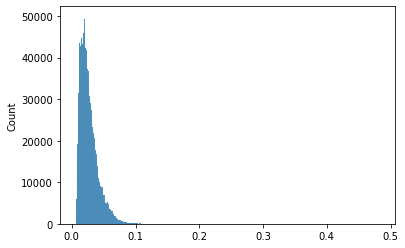

In [216]:
sns.histplot(test_pred)